<center><img src="http://www.exalumnos.usm.cl/wp-content/uploads/2015/06/Isotipo-Negro.gif" title="Title text" width="30%" /></center>

<hr style="height:2px;border:none"/>
<h1 align='center'> INF-310 </h1>

<H3 align='center'> Procesamiento de series de tiempo </H3>
<hr style="height:2px;border:none"/>

**Autor**

*   Tomás Berríos





# Transformación de series de tiempo a un espacio bidimensional

**Descripción**
> Este problema consiste en ...

**Recursos:**
> ...

# Imports

In [1]:
import tensorflow as tf
from tensorflow import keras

print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

tf.test.is_built_with_cuda()

Num GPUs Available:  1


True

In [2]:
import tensorflow as tf

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, Activation, Flatten, Dropout, BatchNormalization
from tensorflow.keras.layers import Conv2D, GlobalAvgPool2D, MaxPool2D

from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications import ResNet152V2, InceptionV3

from tensorflow.keras.optimizers import RMSprop


from keras.utils.vis_utils import plot_model


from sklearn.metrics import mean_squared_error

from sklearn.neighbors import KernelDensity
from sklearn.mixture import GaussianMixture

from sklearn.model_selection import train_test_split



from scipy.special import rel_entr
from scipy.stats import ks_2samp
from scipy.spatial.distance import jensenshannon


import json
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from pyts.image import MarkovTransitionField
from pyts.image import GramianAngularField

plt.style.use('seaborn-colorblind')

C:\Users\tomas\AppData\Local\Temp\ipykernel_12964\917257267.py:40: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-colorblind')


Seteando la semilla aleatoria para una posterior replicación de los resultados

In [3]:
def setup_seed(seed):
    random.seed(seed)  
    np.random.seed(seed) 
    tf.random.set_seed(seed)  # tf cpu fix seed
    #os.environ['TF_DETERMINISTIC_OPS'] = '1'  # tf gpu fix seed, please `pip install tensorflow-determinism` first

setup_seed(1)

Seteando ruta del notebook

In [4]:
path = 'C:\\Users\\tomas\\Documents\\TT\\Models\\Quantiles\\Scale_day_trimester\\'

# Dataset



In [5]:
csv_name = 'C:\\Users\\tomas\\Documents\\TT\\datasets-ozono\\dump-Las_Condes_2018-04-12_230000-completo.csv'
df = pd.read_csv(csv_name)
df

,registered_on,CH4,CO,PM10,PM25,NO2,NO,NOX,SO2,WD,RH,TEMP,WS,HCNM,UVA,UVB,O3
0,1997-04-02 01:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0
1,1997-04-02 02:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0
2,1997-04-02 03:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0
3,1997-04-02 04:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0
4,1997-04-02 05:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
181238,2018-04-12 19:00:00,NaN,NaN,80.0,26.0,NaN,NaN,NaN,NaN,NaN,58.6725,19.1946,NaN,NaN,0.0,0.0,NaN
181239,2018-04-12 20:00:00,NaN,NaN,84.0,25.0,NaN,NaN,NaN,NaN,NaN,62.4218,17.8859,NaN,NaN,0.0,0.0,NaN
181240,2018-04-12 21:00:00,NaN,NaN,66.0,24.0,NaN,NaN,NaN,NaN,NaN,66.3420,16.6689,NaN,NaN,0.0,0.0,NaN
181241,2018-04-12 22:00:00,NaN,NaN,63.0,18.0,NaN,NaN,NaN,NaN,NaN,68.4241,15.8009,NaN,NaN,0.0,0.0,NaN


# Pre procesamiento

## Pre procesamiento general

In [6]:
df[['registered_on_day', 'registered_on_hour']] = df.registered_on.str.split(' ', expand=True)
df.registered_on = pd.to_datetime(df.registered_on)
df = df.sort_values(by="registered_on")
df

,registered_on,CH4,CO,PM10,PM25,NO2,NO,NOX,SO2,WD,RH,TEMP,WS,HCNM,UVA,UVB,O3,registered_on_day,registered_on_hour
0,1997-04-02 01:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,1997-04-02,01:00:00
1,1997-04-02 02:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,1997-04-02,02:00:00
2,1997-04-02 03:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,1997-04-02,03:00:00
3,1997-04-02 04:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,1997-04-02,04:00:00
4,1997-04-02 05:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,1997-04-02,05:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
181238,2018-04-12 19:00:00,NaN,NaN,80.0,26.0,NaN,NaN,NaN,NaN,NaN,58.6725,19.1946,NaN,NaN,0.0,0.0,NaN,2018-04-12,19:00:00
181239,2018-04-12 20:00:00,NaN,NaN,84.0,25.0,NaN,NaN,NaN,NaN,NaN,62.4218,17.8859,NaN,NaN,0.0,0.0,NaN,2018-04-12,20:00:00
181240,2018-04-12 21:00:00,NaN,NaN,66.0,24.0,NaN,NaN,NaN,NaN,NaN,66.3420,16.6689,NaN,NaN,0.0,0.0,NaN,2018-04-12,21:00:00
181241,2018-04-12 22:00:00,NaN,NaN,63.0,18.0,NaN,NaN,NaN,NaN,NaN,68.4241,15.8009,NaN,NaN,0.0,0.0,NaN,2018-04-12,22:00:00


In [7]:
def check_null_x(data, k_i, k_j):
    return data[k_i:k_j][np.isnan(data[k_i:k_j])].shape[0] == 0

def check_null_y(data, k_i, k_j, tol):
    n = k_j - k_i
    count = data[k_i:k_j][np.isnan(data[k_i:k_j])].shape[0]
    if float(count/n) <= tol:
        return True
    else:
        return False
    
def pre_process(df, input_scale, k_horizon, output_scale, tol = 0.1):

    data_per_day = None
    output_k_horizon = None

    if input_scale == 'day':
        df = df.groupby(['registered_on_day']).mean()
        data_per_day = np.array(df)
        data = data_per_day

        if output_scale == 'month':
            output_k_horizon = 30
        elif output_scale == 'trimester':
            output_k_horizon = 90
        elif output_scale == 'year':
            output_k_horizon = 365
        else:
            print('Escala de tiempo de output incorrecto')
            return None, None

    elif input_scale == 'hour':
        data = np.array(df.O3)
        df = df.groupby(['registered_on_day']).mean()
        data_per_day = np.array(df.O3)

    n, m = data.shape

    pre_X = np.zeros(shape = (1, m, k_horizon))
    pre_y = np.zeros(shape = (1, output_k_horizon))
  
    for i in range(0, n):

        k_i = i
        k_j = i + k_horizon

        if k_j + output_k_horizon > n:
            break
        else:
            if check_null_x(data[:, -1], k_i, k_j) and check_null_y(data[:, -1], k_j, k_j + output_k_horizon, tol):
                pre_X = np.append(pre_X, [data[k_i:k_j, :].T], axis=0)
                pre_y = np.append(pre_y, [data[k_j:k_j + output_k_horizon, -1] ], axis=0)
    return pre_X[1:], pre_y[1:]

## Pre procesamiento X

In [8]:
def normalize_data(data, min, max):
    return (data - min) / (max - min)

### Gramian Angular Field (GAF)

In [9]:
def normalization(X):
    max_X = np.max(X)
    min_X = np.min(X)
    C = max_X - min_X
    X_ = np.array([((x_i - max_X) + (x_i - min_X))/C for x_i in X])
    return X_

def inner_product(x_1, x_2):
    return x_1*x_2 - np.sqrt(1 - x_2*x_2)

def GAF_(pre_X):
    n, m = pre_X.shape
    X = np.zeros(shape = (n, m, m))
    for k in range(0, n):
        X_k = normalization(pre_X[k])
        for i in range(0, m):
            for j in range(0, m):
                X[k, i, j] = inner_product(X_k[i], X_k[j])
    return X

def GAF(X, method):
    transformer = GramianAngularField(method=method, image_size=X.shape[1])
    GAF_matrix = transformer.transform(X)
    return GAF_matrix


### Markov Transition Field (MTF)

In [10]:
def MTF(X):
    transformer = MarkovTransitionField(image_size=X.shape[1])
    MTF_matrix = transformer.transform(X)
    return MTF_matrix

### Recurrence Plots (RP)

In [11]:
def RP(X, epsilon):
    m, n = X.shape
    RP = []
    for k in range(0, m):
        GAF_matrix = np.zeros((n, n))
        for i in range(0, n):
            for j in range(0, n):
                if np.abs(X[k,i] - X[k, j]) <  epsilon:
                    GAF_matrix[i, j] = 1
                else:
                    GAF_matrix[i, j] = 0
        RP.append(GAF_matrix)
    return np.array(RP)

### Merge

In [12]:
def merge_data(list_data):
    n_data = list_data[0].shape[0]
    n_layer = len(list_data)
    shape_data = list_data[0].shape[1:]

    new_shape = (n_data,) + shape_data + (n_layer,)
    X = np.zeros(shape = new_shape)
    for i in range(0, n_data):
        for k_i in range(0, shape_data[0]):
            for k_j in range(0, shape_data[1]):
                for j in range(0, n_layer):
                    X[i, k_i, k_j, j] = list_data[j][i, k_i, k_j]
    return X

## Pre procesamiento y

### Quantiles

In [13]:
def get_quantiles(data, n_bins):
    sample = data
    sample = sample[~np.isnan(sample)]
    sample = np.sort(sample)
    quantil_i = 1 / n_bins

    y_i = np.zeros(shape = (n_bins + 1))
    for i in range(1, n_bins):
        y_i[i] = np.quantile(sample, i*quantil_i)

    IQR = y_i[3] - y_i[1]

    lower_whisker = np.min(sample[sample > y_i[1] - 1.5*IQR])
    upper_whisker = np.max(sample[sample < y_i[3] + 1.5*IQR])

    y_i[0], y_i[-1] = (lower_whisker, upper_whisker)

    return y_i

# Quantiles

## Models

In [14]:
def get_custom_model_3_conv(input_shape, output_activation, n_neuron):
    input = Input(shape=input_shape)

    conv_1 = Conv2D(32, (3, 3), padding='same', activation="relu")(input)
    conv_2 = Conv2D(32, (3, 3), padding='same', activation="relu")(conv_1)
    maxpool_1 = MaxPool2D((2,2), padding='same')(conv_2)
    dropout_1 = Dropout(0.25)(maxpool_1)

    conv_3 = Conv2D(64, (3, 3), padding='same', activation="relu")(dropout_1)
    conv_4 = Conv2D(64, (3, 3), padding='same', activation="relu")(conv_3)
    maxpool_2 = MaxPool2D((2,2), padding='same')(conv_4)
    dropout_2 = Dropout(0.25)(maxpool_2)

    conv_5 = Conv2D(128, (3, 3), padding='same', activation="relu")(dropout_2)
    conv_6 = Conv2D(128 , (3, 3), padding='same', activation="relu")(conv_5)

    globalavgpool_1 = GlobalAvgPool2D()(conv_6)
    output = Dense(n_neuron, activation=output_activation)(globalavgpool_1)
    model = Model(inputs=input, outputs=output)

    return model

In [15]:
def get_custom_model_4_conv(input_shape, output_activation, n_neuron):
    input = Input(shape=input_shape)

    conv_1 = Conv2D(32, (3, 3), padding='same', activation="relu")(input)
    conv_2 = Conv2D(32, (3, 3), padding='same', activation="relu")(conv_1)
    maxpool_1 = MaxPool2D((2,2), padding='same')(conv_2)
    dropout_1 = Dropout(0.25)(maxpool_1)

    conv_3 = Conv2D(64, (3, 3), padding='same', activation="relu")(dropout_1)
    conv_4 = Conv2D(64, (3, 3), padding='same', activation="relu")(conv_3)
    maxpool_2 = MaxPool2D((2,2), padding='same')(conv_4)
    dropout_2 = Dropout(0.25)(maxpool_2)

    conv_5 = Conv2D(128, (3, 3), padding='same', activation="relu")(dropout_2)
    conv_6 = Conv2D(128 , (3, 3), padding='same', activation="relu")(conv_5)
    maxpool_3 = MaxPool2D((2,2), padding='same')(conv_6)
    dropout_3 = Dropout(0.25)(maxpool_3)

    conv_7 = Conv2D(128, (3, 3), padding='same', activation="relu")(dropout_3)
    conv_8 = Conv2D(128 , (3, 3), padding='same', activation="relu")(conv_7)

    globalavgpool_1 = GlobalAvgPool2D()(conv_8)
    output = Dense(n_neuron, activation=output_activation)(globalavgpool_1)
    model = Model(inputs=input, outputs=output)

    return model

## Training

In [20]:
def training_model_pipeline(models, losses, input_horizon, epochs, batch_size):

    filepath_saves = []
    filepath_save_base = path + 'checkpoints_model_quantiles\\checkpoint'

    n_comb = len(models)*len(input_horizon)*len(losses)*1
    count = 0
    
    n_bins = 4

    for input_horizon_key in input_horizon:
        pre_X, pre_y = pre_process(df, 'day', input_horizon[input_horizon_key], 'trimester', 0.2)
        
        X_GAF_summation = GAF(pre_X[:, -1, :], 'summation')
        X_GAF_difference = GAF(pre_X[:, -1, :], 'difference')
        X_MTF = MTF(pre_X[:, -1, :])
        X_RP = RP(normalize_data(pre_X[:, -1, :], 0., 50.), 0.1)
        
        n, _ = pre_y.shape
        y_quant = np.zeros(shape= (n, n_bins + 1))
        for i in range(0, n):
              y_quant[i, :] = get_quantiles(pre_y[i], n_bins)
        y = normalize_data(y_quant, 0., 50.)
        
        inputs = {
            'gafs': [X_GAF_summation],
            'gafd': [X_GAF_difference],
            'gafs_gafd': [X_GAF_summation, X_GAF_difference],
            'mtf': [X_MTF],
            'gafs_mtf': [X_GAF_summation, X_MTF],
            'gafd_mtf': [X_GAF_difference, X_MTF],
            'gafs_gafd_mtf': [X_GAF_summation, X_GAF_difference, X_MTF],
            'rp': [X_RP],
            'gafs_rp': [X_GAF_summation, X_RP],
            'gafd_rp': [X_GAF_difference, X_RP],
            'mtf_rp': [X_MTF, X_RP],
            'gafs_mtf_rp': [X_GAF_summation, X_MTF, X_RP],
            'gafd_mtf_rp': [X_GAF_difference, X_MTF, X_RP],
            'gafs_gafd_rp': [X_GAF_summation, X_GAF_difference, X_RP],
            'gafs_gafd_mtf_rp': [X_GAF_summation, X_GAF_difference, X_MTF, X_RP],
        }
        
        for input_key in inputs:

            X = merge_data(inputs[input_key])

            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)
            X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=1)

            for model_key in models:
                for loss_key in losses:

                    print(f'----------------------------- Training model [ {round(100*(count/n_comb), 1)} %] -----------------------------')
                    print('Horizon:', input_horizon_key)
                    print('Input:', input_key)
                    print('Model:', model_key)
                    print('Loss:', loss_key)

                    filepath_save = filepath_save_base + '_' + input_horizon_key + '_' + input_key + '_' + model_key + '_' + loss_key + '.hdf5'
                    filepath_saves.append((filepath_save, input_key, input_key + '_' + model_key + '_' + loss_key))

                    model = models[model_key](X_train.shape[1:], 'linear', 5)
                    model.compile(loss = losses[loss_key], optimizer = 'adam')

                    model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
                        filepath=filepath_save,
                        save_weights_only=False,
                        monitor='val_loss',
                        mode='min',
                        save_best_only=True,
                        verbose=0,
                    )

                    history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_val, y_val), callbacks=[model_checkpoint_callback], verbose=False)

                    print('-------------------------------- End training model --------------------------------')

                    with open(filepath_save + '_loss.json', "w") as f:
                        json.dump(history.history, f)

                    count += 1
                    
                del model
                del history
                del model_checkpoint_callback
                
            del X, X_train, X_val, X_test
            del y_train, y_val, y_test
        
        del pre_X, pre_y
        del X_GAF_summation, X_GAF_difference, X_MTF, X_RP
        del y_quant, y
        del inputs
  
    return filepath_saves

In [17]:
models = {
    '3_conv_layer': get_custom_model_3_conv,
    '4_conv_layer': get_custom_model_4_conv,
}

losses = {
    'mean_squared_error': 'mse',
}

input_horizon = {
    'horizon_15': 15,
    'horizon_30': 30,
    'horizon_45': 45,
    'horizon_60': 60,
    'horizon_75': 75,
}

epochs = 30
batch_size = 32

filepath_saves = training_model_pipeline(models, losses, input_horizon, epochs, batch_size)

KeyboardInterrupt: 

In [17]:
models = {
    '3_conv_layer': get_custom_model_3_conv,
    '4_conv_layer': get_custom_model_4_conv,
}

losses = {
    'mean_squared_error': 'mse',
}

input_horizon = {
    'horizon_60': 60,
    'horizon_75': 75,
}

epochs = 30
batch_size = 32

filepath_saves = training_model_pipeline(models, losses, input_horizon, epochs, batch_size)

----------------------------- Training model [ 0.0 %] -----------------------------
Horizon: horizon_60
Input: gafs
Model: 3_conv_layer
Loss: mean_squared_error
-------------------------------- End training model --------------------------------
----------------------------- Training model [ 1.7 %] -----------------------------
Horizon: horizon_60
Input: gafs
Model: 4_conv_layer
Loss: mean_squared_error
-------------------------------- End training model --------------------------------
----------------------------- Training model [ 3.3 %] -----------------------------
Horizon: horizon_60
Input: gafd
Model: 3_conv_layer
Loss: mean_squared_error
-------------------------------- End training model --------------------------------
----------------------------- Training model [ 5.0 %] -----------------------------
Horizon: horizon_60
Input: gafd
Model: 4_conv_layer
Loss: mean_squared_error
-------------------------------- End training model --------------------------------
----------------

In [21]:
models = {
    '3_conv_layer': get_custom_model_3_conv,
    '4_conv_layer': get_custom_model_4_conv,
}

losses = {
    'mean_squared_error': 'mse',
}

input_horizon = {
    'horizon_90': 90,
}

epochs = 30
batch_size = 16

filepath_saves = training_model_pipeline(models, losses, input_horizon, epochs, batch_size)

----------------------------- Training model [ 0.0 %] -----------------------------
Horizon: horizon_90
Input: gafs_gafd_mtf_rp
Model: 3_conv_layer
Loss: mean_squared_error
-------------------------------- End training model --------------------------------
----------------------------- Training model [ 50.0 %] -----------------------------
Horizon: horizon_90
Input: gafs_gafd_mtf_rp
Model: 4_conv_layer
Loss: mean_squared_error
-------------------------------- End training model --------------------------------


#### Result

In [22]:
def mean_DBM_OVS_metric(y_true, y_pred):
    n, _ = y_true.shape
    dbm_ovs = np.zeros(shape=(n))
    for i in range(0, n):
        dbm_ovs[i] = np.abs(y_true[i, 2]-y_pred[i, 2])/(np.max([y_true[i, 1:4],y_pred[i, 1:4]]) - np.min([y_true[i, 1:4],y_pred[i, 1:4]]))
    return dbm_ovs.mean(axis=0)

def mse_metric(y_true, y_pred):
    return np.square(y_true - y_pred).mean(axis=1).mean(axis=0)

def mae_metric(y_true, y_pred):
    return np.abs(y_true - y_pred).mean(axis=1).mean(axis=0)

def mape_metric(y_true, y_pred):
    return np.abs((y_val - y_pred)/y_val).mean(axis=1).mean(axis=0)

def get_metrics_model(model, X, y_true):
    y_pred = model.predict(X)
    dbm_ovs = mean_DBM_OVS_metric(y_true, y_pred)
    mse = mse_metric(y_true, y_pred)
    mae = mae_metric(y_true, y_pred)
    mape = mape_metric(y_true, y_pred)
    return dbm_ovs, mse, mae, mape

In [23]:
models = {
    '3_conv_layer': get_custom_model_3_conv,
    '4_conv_layer': get_custom_model_4_conv,
}

losses = {
    'mean_squared_error': 'mse',
}

input_horizon = {
    'horizon_15': 15,
    'horizon_30': 30,
    'horizon_45': 45,
    'horizon_60': 60,
    'horizon_75': 75,
    'horizon_90': 90,
}
epochs = 30
batch_size = 32

In [24]:
data = {
    'models': [],
    'DBM/OVS': [],
    'Mean squared error': [],
    'Mean absolute error': [],
    'Mean absolute percentage error': [],
}

filepath_save_base = path + 'checkpoints_model_quantiles\\checkpoint'

n_bins = 4

for input_horizon_key in input_horizon:
    pre_X, pre_y = pre_process(df, 'day', input_horizon[input_horizon_key], 'trimester', 0.2)

    X_GAF_summation = GAF(pre_X[:, -1, :], 'summation')
    X_GAF_difference = GAF(pre_X[:, -1, :], 'difference')
    X_MTF = MTF(pre_X[:, -1, :])
    X_RP = RP(normalize_data(pre_X[:, -1, :], 0., 50.), 0.1)

    n, _ = pre_y.shape
    y_quant = np.zeros(shape= (n, n_bins + 1))
    for i in range(0, n):
          y_quant[i, :] = get_quantiles(pre_y[i], n_bins)
    y = normalize_data(y_quant, 0., 50.)

    inputs = {
        'gafs': [X_GAF_summation],
        'gafd': [X_GAF_difference],
        'gafs_gafd': [X_GAF_summation, X_GAF_difference],
        'mtf': [X_MTF],
        'gafs_mtf': [X_GAF_summation, X_MTF],
        'gafd_mtf': [X_GAF_difference, X_MTF],
        'gafs_gafd_mtf': [X_GAF_summation, X_GAF_difference, X_MTF],
        'rp': [X_RP],
        'gafs_rp': [X_GAF_summation, X_RP],
        'gafd_rp': [X_GAF_difference, X_RP],
        'mtf_rp': [X_MTF, X_RP],
        'gafs_mtf_rp': [X_GAF_summation, X_MTF, X_RP],
        'gafd_mtf_rp': [X_GAF_difference, X_MTF, X_RP],
        'gafs_gafd_rp': [X_GAF_summation, X_GAF_difference, X_RP],
        'gafs_gafd_mtf_rp': [X_GAF_summation, X_GAF_difference, X_MTF, X_RP],
    }

    for input_key in inputs:

        X = merge_data(inputs[input_key])

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)
        X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=1)

        for model_key in models:
            for loss_key in losses:
                filepath_save = filepath_save_base + '_' + input_horizon_key + '_' + input_key + '_' + model_key + '_' + loss_key + '.hdf5'
                model = tf.keras.models.load_model(filepath_save)

                dbm_ovs, mse, mae, mape = get_metrics_model(model, X_val, y_val)
                data['models'].append(input_horizon_key + '_' + input_key + '_' + model_key + '_' + loss_key)
                data['DBM/OVS'].append(round(dbm_ovs, 4))
                data['Mean squared error'].append(round(mse, 4))
                data['Mean absolute error'].append(round(mae, 4))
                data['Mean absolute percentage error'].append(round(mape, 4))

df_result = pd.DataFrame(data=data)

C:\Users\tomas\anaconda3\envs\tt_env\lib\site-packages\pyts\preprocessing\discretizer.py:168: UserWarning: Some quantiles are equal. The number of bins will be smaller for sample [2 3]. Consider decreasing the number of bins or removing these samples.
  warn("Some quantiles are equal. The number of bins will "


In [25]:
df_result.sort_values(by=['DBM/OVS'])

,models,DBM/OVS,Mean squared error,Mean absolute error,Mean absolute percentage error
153,horizon_90_gafd_4_conv_layer_mean_squared_error,0.0658,0.0005,0.0161,0.0812
169,horizon_90_gafd_rp_4_conv_layer_mean_squared_e...,0.0676,0.0006,0.0169,0.0817
139,horizon_75_gafd_rp_4_conv_layer_mean_squared_e...,0.0711,0.0008,0.0198,0.0898
147,horizon_75_gafs_gafd_rp_4_conv_layer_mean_squa...,0.0740,0.0006,0.0176,0.0937
155,horizon_90_gafs_gafd_4_conv_layer_mean_squared...,0.0742,0.0006,0.0172,0.0821
...,...,...,...,...,...
36,horizon_30_mtf_3_conv_layer_mean_squared_error,0.4052,0.0257,0.1340,0.8126
37,horizon_30_mtf_4_conv_layer_mean_squared_error,0.4054,0.0267,0.1359,0.7182
10,horizon_15_gafd_mtf_3_conv_layer_mean_squared_...,0.4200,0.0281,0.1413,0.6221
6,horizon_15_mtf_3_conv_layer_mean_squared_error,0.4248,0.0293,0.1455,0.7942


## Results

In [37]:
def plot_pred_quantiles(model, X, y_true, n_bins, n_samples, random_pick, pick_list = []):

    y_pred = model.predict(X)

    n = y_true.shape[0]
    if random_pick:
        pick_list = random.sample([i for i in range(0, n)], n_samples)
    else:
        if len(pick_list) != n_samples:
            return None

    n_col = 2
    n_row = int(np.ceil(n_samples / n_col))
    fig, axes = plt.subplots(n_row, n_col, figsize = (int(n_row*6), int(n_col*12)))

    for i in range(0, n_samples):

        axes_i = int(i / n_col)
        axes_j = i % n_col
        sample = [y_pred[pick_list[i]], y_true[pick_list[i]]]
        axes[axes_i][axes_j].boxplot(sample, labels=['predicted quantiles', 'true quantiles'], whis=[0, 100])
        axes[axes_i][axes_j].set_title(f'Quantiles n°{pick_list[i] + 1}')

    plt.subplots_adjust(left=0.1,
      bottom=0.1, 
      right=0.9, 
      top=0.9, 
      wspace=0.2, 
      hspace=0.2
    )
  
    return None

In [36]:
def plot_loss_history(path_history):
    with open(path_history, "r") as f:
        history = json.loads(f.read())
        n_epochs = len(history['loss'])
        data = [i for i in range(0, n_epochs)]

        fig, ax = plt.subplots(figsize = (11, 6))

        ax.plot(data, history['loss'], color='orange', label='Loss')
        ax.plot(data, history['val_loss'], color='blue', label='Validation Loss')

        ax.legend()
        ax.set_title('Loss per Epochs')
        ax.set_xlabel('Epochs')
        ax.set_ylabel('MSE')

        plt.show()

    return None

In [29]:
def mean_DBM_OVS_metric(y_true, y_pred):
    n, _ = y_true.shape
    dbm_ovs = np.zeros(shape=(n))
    for i in range(0, n):
        dbm_ovs[i] = np.abs(y_true[i, 2]-y_pred[i, 2])/(np.max([y_true[i, 1:4],y_pred[i, 1:4]]) - np.min([y_true[i, 1:4],y_pred[i, 1:4]]))
    return dbm_ovs.mean(axis=0)

def mse_metric(y_true, y_pred):
    return np.square(y_true - y_pred).mean(axis=1).mean(axis=0)

def mae_metric(y_true, y_pred):
    return np.abs(y_true - y_pred).mean(axis=1).mean(axis=0)

def mape_metric(y_true, y_pred):
    return np.abs((y_val - y_pred)/y_val).mean(axis=1).mean(axis=0)

def get_metrics_model(model, X, y_true):
    y_pred = model.predict(X)
    dbm_ovs = mean_DBM_OVS_metric(y_true, y_pred)
    mse = mse_metric(y_true, y_pred)
    mae = mae_metric(y_true, y_pred)
    mape = mape_metric(y_true, y_pred)
    return dbm_ovs, mse, mae, mape

In [27]:
models = {
    '3_conv_layer': get_custom_model_3_conv,
    '4_conv_layer': get_custom_model_4_conv,
}

losses = {
    'mean_squared_error': 'mse',
}

inputs = {
          'gafs': [X_GAF_summation],
          'gafd': [X_GAF_difference],
          'gafs_gafd': [X_GAF_summation, X_GAF_difference],
          'mtf': [X_MTF],
          'gafs_mtf': [X_GAF_summation, X_MTF],
          'gafd_mtf': [X_GAF_difference, X_MTF],
          'gafs_gafd_mtf': [X_GAF_summation, X_GAF_difference, X_MTF],
          'rp': [X_RP],
          'gafs_rp': [X_GAF_summation, X_RP],
          'gafd_rp': [X_GAF_difference, X_RP],
          'mtf_rp': [X_MTF, X_RP],
          'gafs_mtf_rp': [X_GAF_summation, X_MTF, X_RP],
          'gafd_mtf_rp': [X_GAF_difference, X_MTF, X_RP],
          'gafs_gafd_rp': [X_GAF_summation, X_GAF_difference, X_RP],
          'gafs_gafd_mtf_rp': [X_GAF_summation, X_GAF_difference, X_MTF, X_RP],
}

epochs = 30
batch_size = 32

In [30]:
data = {
    'models': [],
    'DBM/OVS': [],
    'Mean squared error': [],
    'Mean absolute error': [],
    'Mean absolute percentage error': [],
}

filepath_save_base = 'C:\\Users\\tomas\\Documents\\TT\\checkpoints_model_quantiles\\checkpoint'

for input_key in inputs:

    X = merge_data(inputs[input_key])

    X_train, X_test, y_train, y_test = train_test_split(X, y_norm_quant, test_size=0.3, random_state=1)
    X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=1)

    for model_key in models:
        for loss_key in losses:

            filpath_save = filepath_save_base + '_' + input_key + '_' + model_key + '_' + loss_key + '.hdf5'

            model = tf.keras.models.load_model(filpath_save)

            dbm_ovs, mse, mae, mape = get_metrics_model(model, X_val, y_val)
            data['models'].append(input_key + '_' + model_key + '_' + loss_key)
            data['DBM/OVS'].append(round(dbm_ovs, 4))
            data['Mean squared error'].append(round(mse, 4))
            data['Mean absolute error'].append(round(mae, 4))
            data['Mean absolute percentage error'].append(round(mape, 4))

df_result = pd.DataFrame(data=data)

In [32]:
df_result.sort_values(by=['DBM/OVS'])

,models,DBM/OVS,Mean squared error,Mean absolute error,Mean absolute percentage error
29,gafs_gafd_mtf_rp_4_conv_layer_mean_squared_error,0.1366,0.0021,0.0333,0.1545
25,gafd_mtf_rp_4_conv_layer_mean_squared_error,0.1389,0.0023,0.0350,0.1414
27,gafs_gafd_rp_4_conv_layer_mean_squared_error,0.1408,0.0025,0.0361,0.1445
24,gafd_mtf_rp_3_conv_layer_mean_squared_error,0.1408,0.0025,0.0374,0.1598
3,gafd_4_conv_layer_mean_squared_error,0.1428,0.0021,0.0329,0.1530
19,gafd_rp_4_conv_layer_mean_squared_error,0.1440,0.0022,0.0342,0.1484
11,gafd_mtf_4_conv_layer_mean_squared_error,0.1504,0.0024,0.0352,0.1576
13,gafs_gafd_mtf_4_conv_layer_mean_squared_error,0.1504,0.0027,0.0374,0.1682
18,gafd_rp_3_conv_layer_mean_squared_error,0.1526,0.0028,0.0390,0.1485
10,gafd_mtf_3_conv_layer_mean_squared_error,0.1565,0.0028,0.0393,0.2012


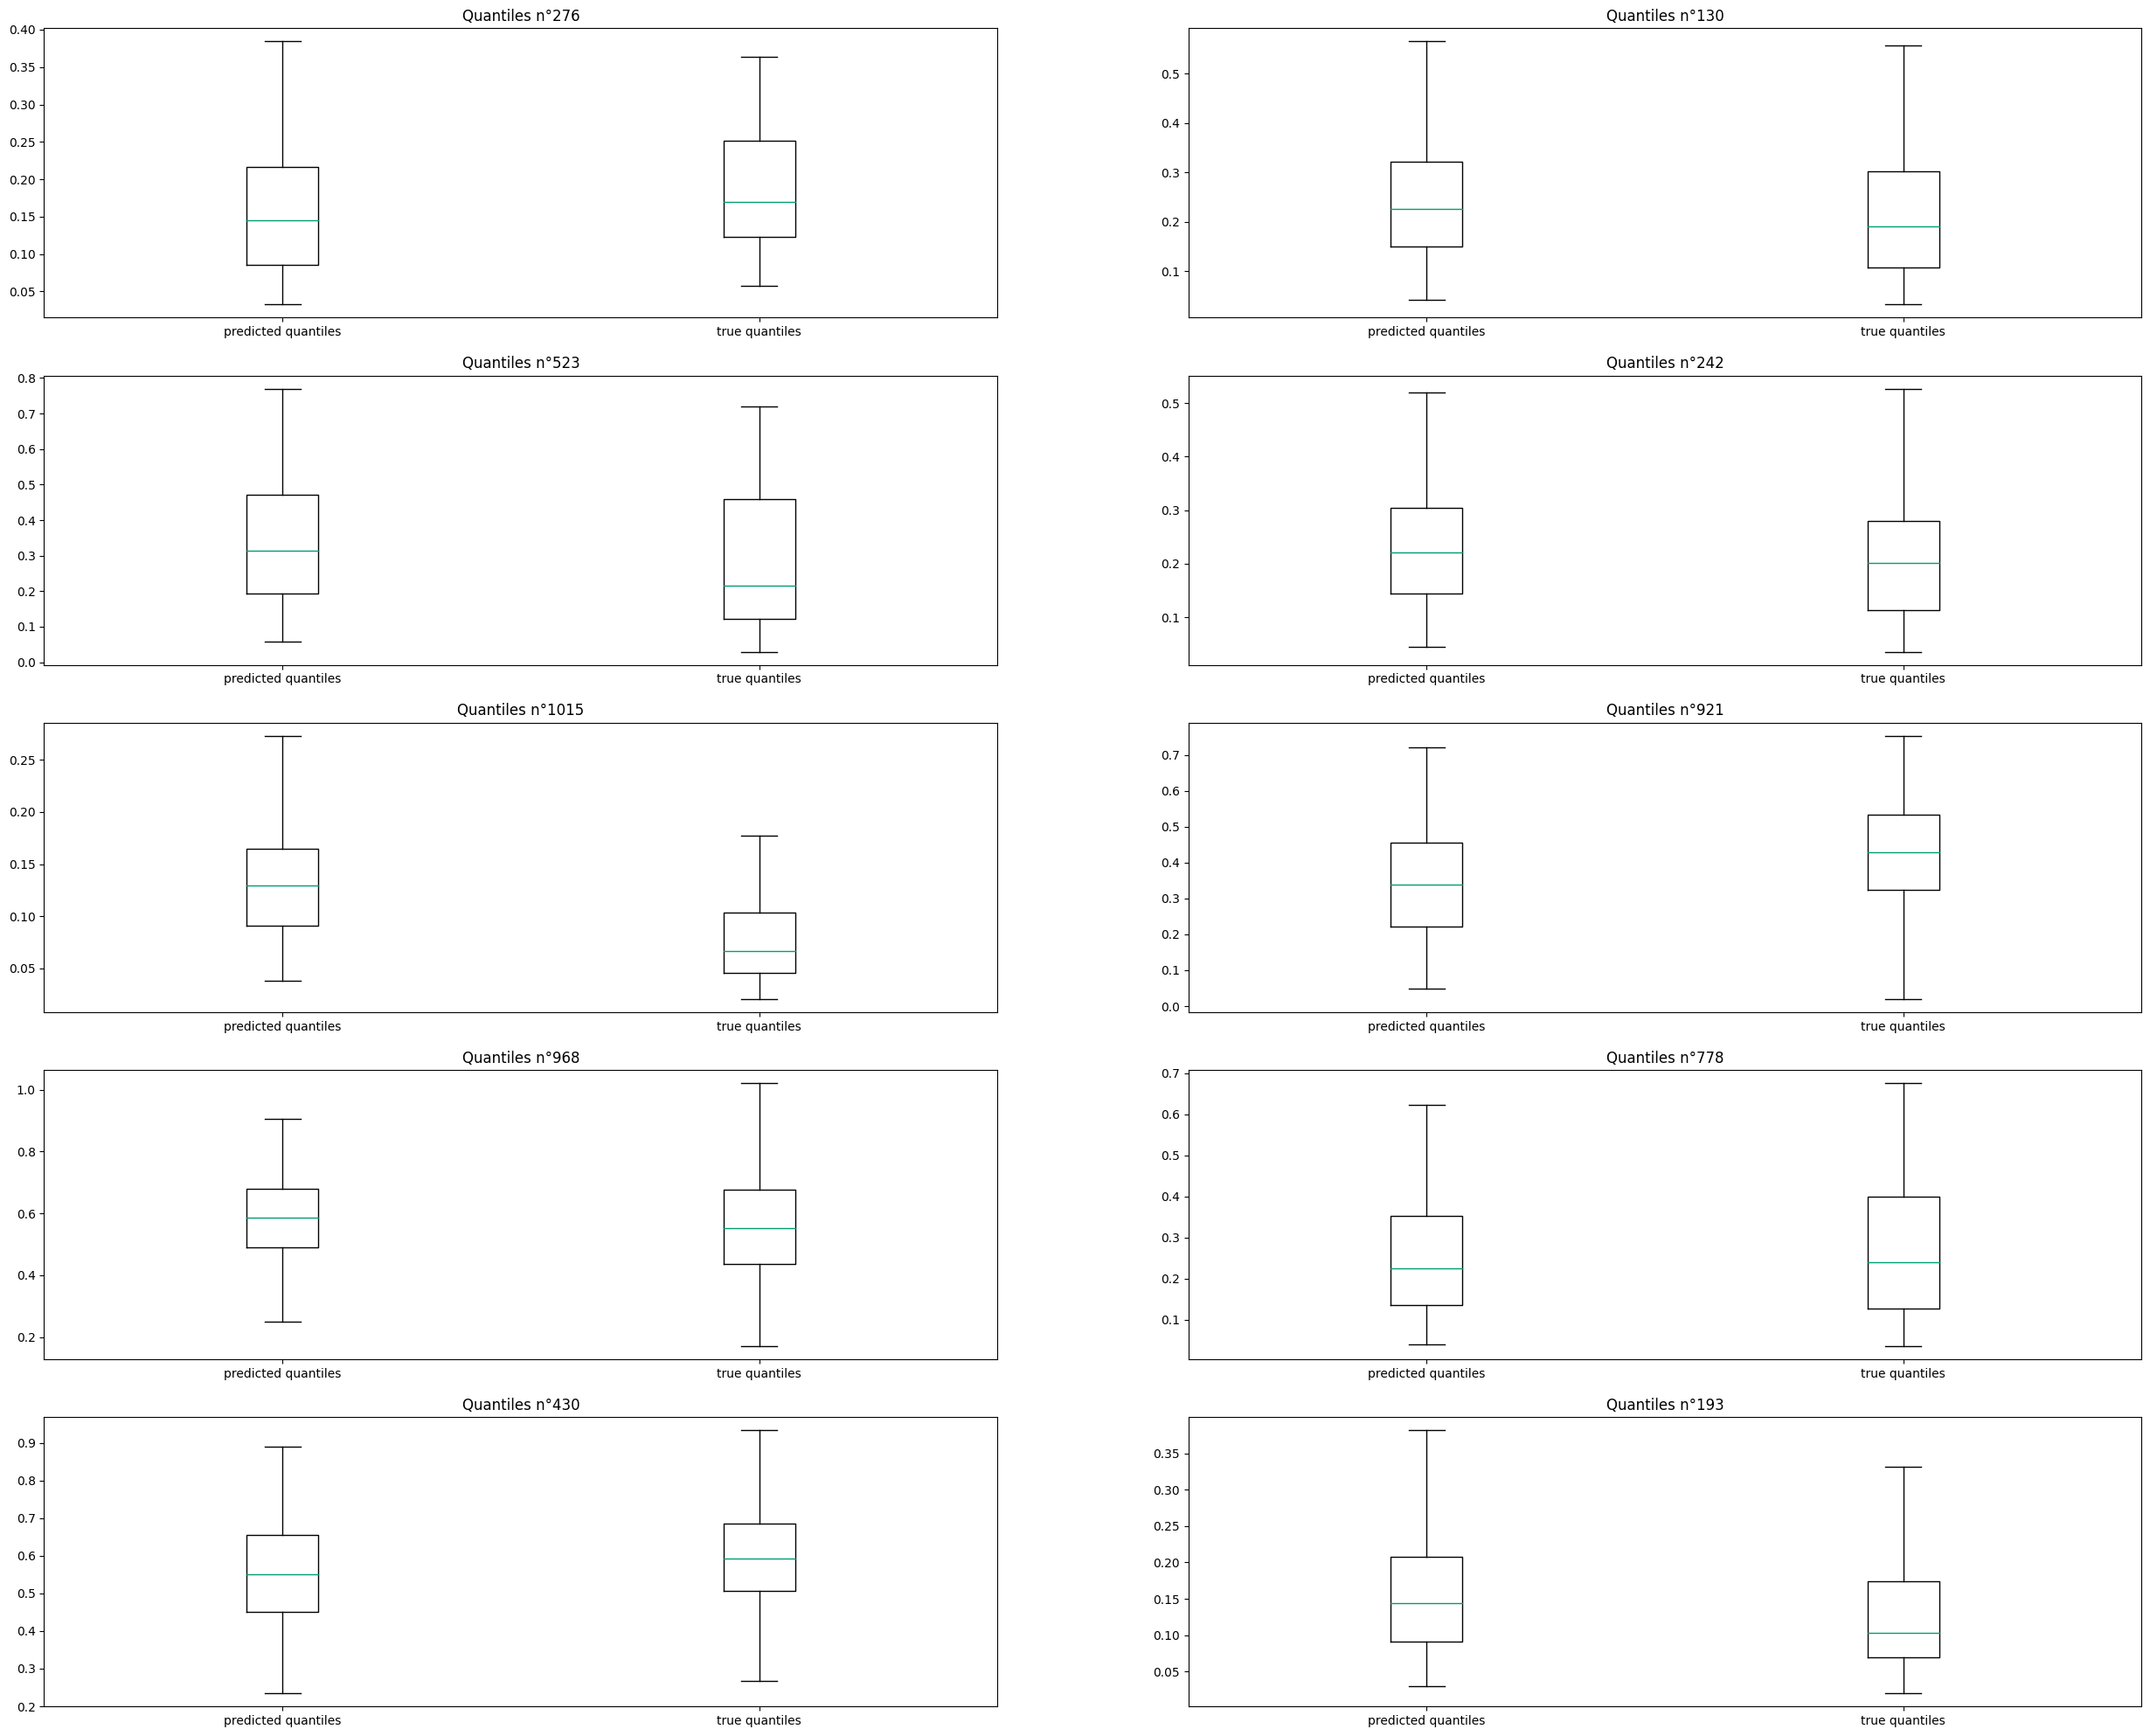

In [39]:
filepath_save_base = 'C:\\Users\\tomas\\Documents\\TT\\checkpoints_model_quantiles\\checkpoint'
filepath = 'mtf_rp_4_conv_layer_mean_squared_error'
filepath = 'gafs_gafd_mtf_rp_4_conv_layer_mean_squared_error'
model_filepath = filepath_save_base + '_' + filepath + '.hdf5'

X = merge_data(inputs['gafs_gafd_mtf_rp'])

X_train, X_test, y_train, y_test = train_test_split(X, y_norm_quant, test_size=0.3, random_state=1)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=1)

model = tf.keras.models.load_model(model_filepath)

n_bins = 10
n_samples = 10
plot_pred_quantiles(model, X_val, y_val, n_bins, n_samples, True)

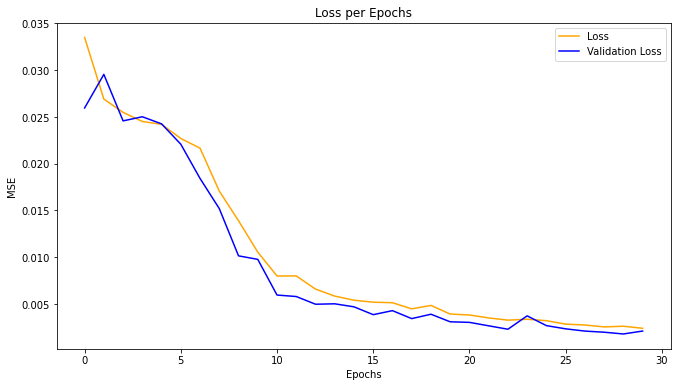

In [31]:
plot_loss_history(model_filepath + '_loss.json')